In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from collections import Counter


img_dir = '/content/drive/MyDrive/485Fashion'

# Initialize variables for analysis
heights, widths = [], []
color_means = []
aspect_ratios = []

# Analyze each image
for img_file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_file)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)
    aspect_ratios.append(round(w / h, 2))  # Aspect ratio calculation
    color_means.append(cv2.mean(img)[:3])  # Calculate mean color per channel

# Calculate stats
height_range = (min(heights), max(heights))
width_range = (min(widths), max(widths))
common_aspect_ratios = Counter(aspect_ratios).most_common(5)  # Top 5 aspect ratios
color_mean = np.mean(color_means, axis=0)

print(f"Height range: {height_range}")
print(f"Width range: {width_range}")
print("Most common aspect ratios:", common_aspect_ratios)
print("Average color per channel (BGR):", color_mean)






Height range: (300, 1080)
Width range: (300, 1280)
Most common aspect ratios: [(1.0, 483), (0.7, 1), (1.78, 1)]
Average color per channel (BGR): [134.68413984 140.52437316 153.39743266]


In [113]:
def apply_clahe(img_array):
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def resize_with_aspect_ratio(img, target_size=(300, 300)):
    h, w = img.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    delta_w, delta_h = target_size[1] - new_w, target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])



def remove_colored_bubbles(img):
    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

     # Define HSV range for nearly transparent colors
    lower_color = np.array([0, 35, 35])     # Low hue, very low saturation, high value (close to white) https://colorizer.org/ https://hyperskill.org/learn/step/13179
    upper_color = np.array([360, 40, 45])  # Wide hue, low saturation, max value (brightness)

    # Create a mask for colored bubbles
    mask = cv2.inRange(hsv, lower_color, upper_color)

    # Invert the mask to keep only non-colored areas (i.e., the background)
    mask_inv = cv2.bitwise_not(mask)

    # Apply mask to the original image
    background_only = cv2.bitwise_and(img, img, mask=mask_inv)

    # Optionally, apply further processing (e.g., Gaussian blur to smooth the image)
    background_only = cv2.GaussianBlur(background_only, (3, 3), 0)

    return background_only

def apply_edge_detection(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use Canny edge detection
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Convert edges back to 3-channel format
    edges_3d = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges_3d


def preprocess_image(img_path, target_size=(300, 300), use_clahe=True, mask_bubbles=False, use_edge_detection=False):
    # Load image
    img = cv2.imread(img_path)

    # Resize with aspect ratio preservation to 300x300
    img = resize_with_aspect_ratio(img, target_size)

    # Optionally remove colored bubbles
    if mask_bubbles:
        img = remove_colored_bubbles(img)

    # Optionally apply CLAHE for contrast enhancement
    if use_clahe:
        img = apply_clahe(img)

    # Optionally apply edge detection
    if use_edge_detection:
        img = apply_edge_detection(img)

    # Optionally apply Gaussian blur if images have noise
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Convert to array and normalize for the model
    img_array = np.expand_dims(img, axis=0)
    img_array = preprocess_input(img_array)  # Adjust for your model

    return img_array

In [134]:
import numpy as np
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
import random

# Directory with images
img_dir = '/content/drive/MyDrive/485Fashion'

# Step 1: Load the model and preprocess image function
# Pretrained ResNet50 model for object recognition
resnet_model = ResNet50(weights='imagenet', include_top=True)

# Step 2: Extract features (assuming this function has been run, as provided above)
def extract_features(img_dir, model, preprocess_func, target_size=(300, 300)):
    features = []
    img_names = []
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        img_array = preprocess_image(img_path, target_size)
        feature = model.predict(img_array).flatten()
        features.append(feature)
        img_names.append(img_file)
    return np.array(features), img_names

# Step 3: Standardize and apply KMeans clustering (assuming this is done)
# Example feature extraction and clustering setup
features, img_names = extract_features(img_dir, ResNet50(weights='imagenet', include_top=False, pooling='avg'), preprocess_input)
scaler = StandardScaler()
features = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=15, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Step 4: Predict labels for each cluster using ResNet50
def generate_labels_from_predictions(cluster_labels, img_names, img_dir, resnet_model, n_samples=5, top_n=3):
    cluster_labels_dict = {}
    for cluster in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        sample_indices = random.sample(list(cluster_indices), min(n_samples, len(cluster_indices)))
        predictions = []

        for idx in sample_indices:
            img_path = os.path.join(img_dir, img_names[idx])
            img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224 for prediction
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Get top-n predictions
            preds = resnet_model.predict(img_array)
            decoded_preds = decode_predictions(preds, top=top_n)[0]
            top_predictions = [pred[1] for pred in decoded_preds]  # Collect top-n predicted labels
            predictions.extend(top_predictions)

        # Assign a combined label for this cluster
        common_labels = [label for label, _ in Counter(predictions).most_common(2)]
        cluster_label = "/".join(common_labels)
        cluster_labels_dict[cluster] = cluster_label

    return cluster_labels_dict

# Step 5: Generate and display descriptive labels for each cluster
cluster_labels_dict = generate_labels_from_predictions(cluster_labels, img_names, img_dir, resnet_model)
print("Cluster Descriptive Labels:")
for cluster, label in cluster_labels_dict.items():
    print(f"Cluster {cluster}: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

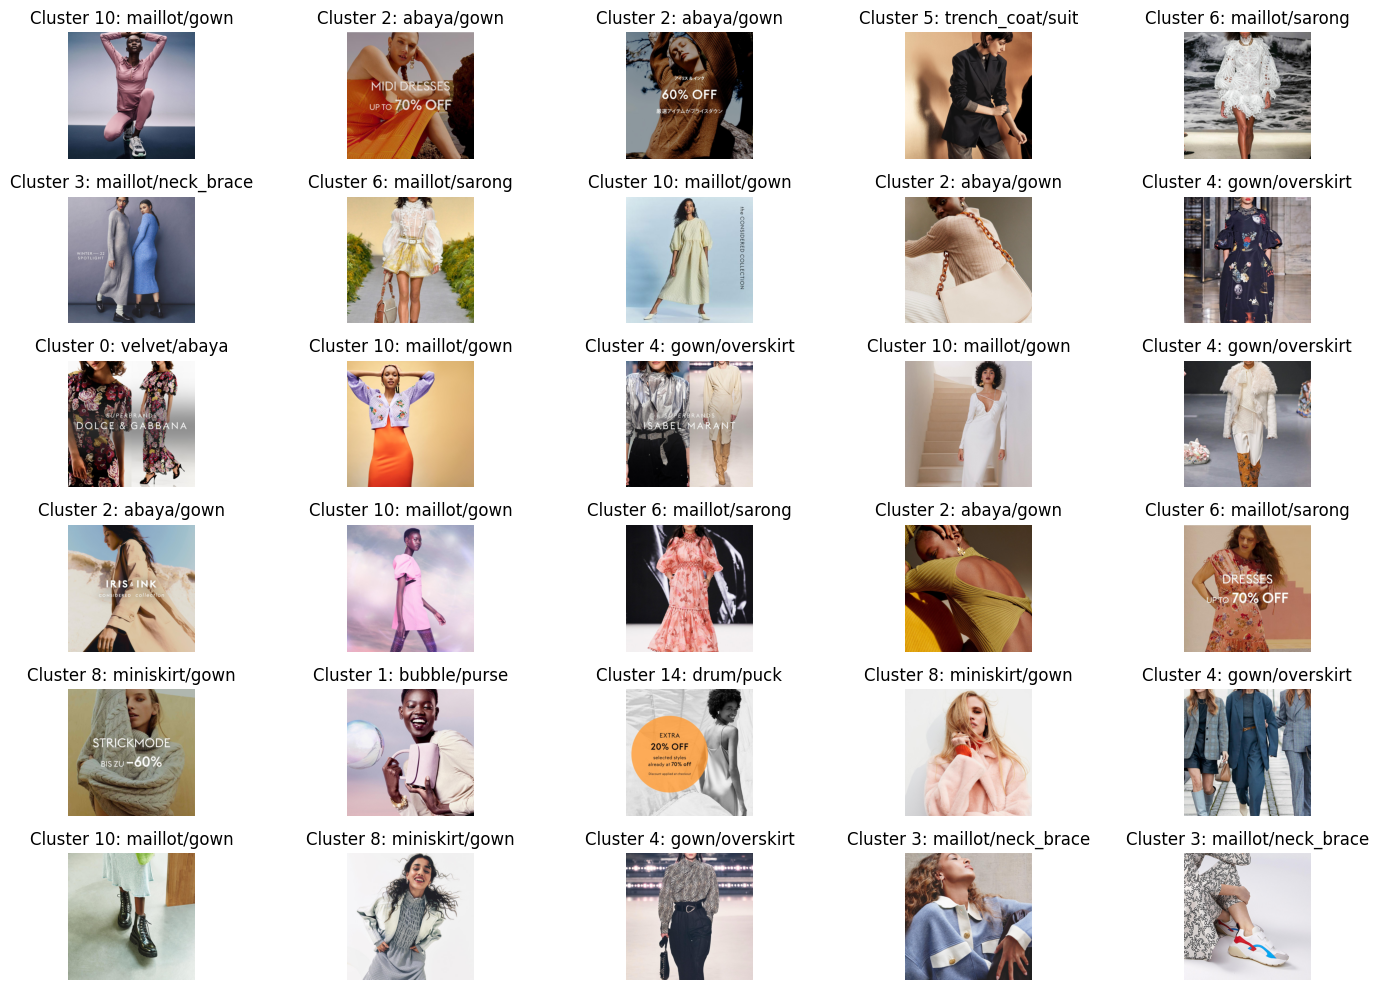

In [135]:
import matplotlib.pyplot as plt

# Step 3: Display 10 images with their corresponding cluster labels
def display_images_with_labels(cluster_labels, img_names, img_dir, cluster_labels_dict, num_samples=30):
    # Randomly select 10 images
    selected_indices = random.sample(range(len(img_names)), num_samples)

    # Plot the images with their labels
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_indices):
        img_path = os.path.join(img_dir, img_names[idx])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get the cluster label for the image
        cluster = cluster_labels[idx]
        label = cluster_labels_dict.get(cluster, "Unknown")

        # Display the image with its label
        plt.subplot(6, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Cluster {cluster}: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 images with cluster labels
display_images_with_labels(cluster_labels, img_names, img_dir, cluster_labels_dict)

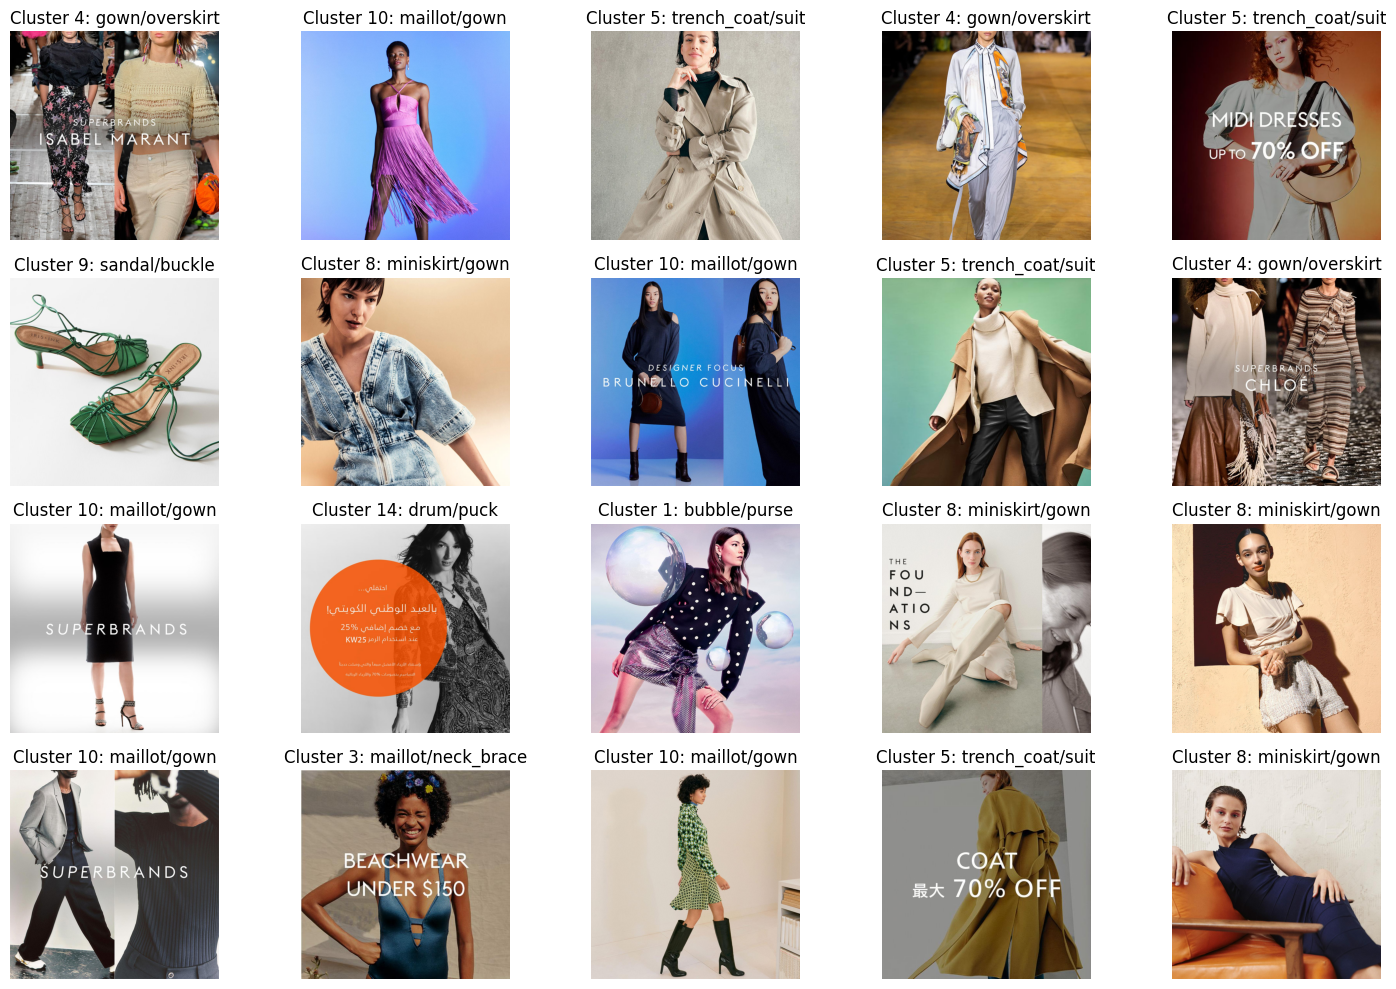

In [136]:


# Step 3: Display 10 images with their corresponding descriptive cluster labels
def display_images_with_cluster_descriptions(cluster_labels, img_names, img_dir, cluster_labels_dict, num_samples=20):
    # Randomly select 10 images
    selected_indices = random.sample(range(len(img_names)), num_samples)

    # Plot the images with their cluster descriptions
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_indices):
        img_path = os.path.join(img_dir, img_names[idx])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get the cluster and the corresponding descriptive label
        cluster = cluster_labels[idx]
        descriptive_label = cluster_labels_dict.get(cluster, "Unknown")

        # Display the image with its descriptive cluster label
        plt.subplot(4, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Cluster {cluster}: {descriptive_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 10 images with descriptive cluster labels
display_images_with_cluster_descriptions(cluster_labels, img_names, img_dir, cluster_labels_dict)
